In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, StringType, DoubleType
import pyspark.sql.functions as F
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipaddress

spark = SparkSession.builder \
    .appName("DDoS Detection Optimized") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "8") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.local.dir", "/tmp/spark") \
    .getOrCreate()

spark.conf.set("spark.sql.adaptive.enabled", "true")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/31 09:44:01 WARN Utils: Your hostname, Aspire-A715-42G, resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlp4s0)
25/05/31 09:44:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/31 09:44:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/31 09:44:02 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).


In [7]:
import pandas as pd
pdf = df = pd.read_parquet("data.parquet").sample(frac=0.05)
df = spark.createDataFrame(pdf)
# df = spark.read.csv(path, header=True, inferSchema=True)


In [8]:
def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return None
num_rows = df.count()
num_cols = len(df.columns)
print(num_rows, num_cols)

25/05/31 09:44:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/31 09:44:44 WARN TaskSetManager: Stage 0 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
[Stage 0:===================================>                    (41 + 14) / 64]

639731 85


In [9]:
%%time
ip_to_int_udf = udf(ip_to_int, IntegerType())

df = df.withColumn("Src IP", ip_to_int_udf(col("Src IP"))) \
       .withColumn("Dst IP", ip_to_int_udf(col("Dst IP")))

# for col_name in df.columns:
#     null_count = df.filter(col(col_name).isNull()).count()
#     if null_count > 0:
#         print(f"Found {null_count} missing values in {col_name}")

null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()
df = df.dropna()
num_rows = df.count()
num_cols = len(df.columns)
print(num_rows, num_cols)

25/05/31 09:46:05 WARN TaskSetManager: Stage 3 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

+----------+-------+------+--------+------+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+------------

25/05/31 09:46:11 WARN TaskSetManager: Stage 6 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
[Stage 6:==================================================>      (57 + 7) / 64]

638205 85
CPU times: user 320 ms, sys: 203 ms, total: 523 ms
Wall time: 12.7 s


In [6]:
# kewed = spark.createDataFrame(frequency_stats)
# colsToDrop = skewed.filter(col("frequency") >= 0.95).select("col").rdd.flatMap(lambda x: x).collect()

# df = df.drop(*colsToDrop)

# numeric_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType))]
# for col_name in numeric_columns:
#     df = df.withColumn(col_name, 
#                       F.when(F.isnan(col(col_name)) | F.isnull(col(col_name)), None)
#                       .otherwise(col(col_name)))



# new_null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).count()

# negValCols = ['Src IP', 'Dst IP', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Max', 
#               'Flow IAT Min', 'Init Bwd Win Byts', 'Bwd IAT Tot', 'Bwd IAT Mean', 
#               'Bwd IAT Max', 'Bwd IAT Min']

# for col_name in negValCols:
#     if col_name in df.columns:
#         df = df.filter(col(col_name) >= 0)
df_copy = df.cache()
num_rows = df.count()
num_cols = len(df.columns)
print(num_rows, num_cols)

25/05/31 08:49:15 WARN TaskSetManager: Stage 9 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:49:27 WARN TaskSetManager: Stage 10 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


638225 85


In [10]:
%%time
most_important_features = [
    "Tot Fwd Pkts",
    "Tot Bwd Pkts",
    "Fwd Pkt Len Max",
    "TotLen Fwd Pkts",
    "Init Bwd Win Byts",
    "Bwd Pkt Len Std",
    "Flow Duration",
    "Fwd IAT Mean",
    "Flow IAT Min",
    "Bwd IAT Tot",
    "SYN Flag Cnt",
    "RST Flag Cnt",
    "Flow Pkts/s",
    "Flow Byts/s",
    "Label"
]

colsToUse = [col for col in most_important_features if col in df.columns]
df = df.select(colsToUse)

for feature in df.columns:
    if feature not in ["Label", "Src Port", "Src IP", "Dst IP"]:
        quantile = df.approxQuantile(feature, [0.95], 0.01)
        if quantile:
            soft_upper = quantile[0]
            df = df.withColumn(feature, 
                             F.when(col(feature) > soft_upper, soft_upper)
                              .otherwise(col(feature)))

25/05/31 09:46:39 WARN TaskSetManager: Stage 9 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:46:44 WARN TaskSetManager: Stage 11 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:46:49 WARN TaskSetManager: Stage 13 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:46:52 WARN TaskSetManager: Stage 15 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:46:57 WARN TaskSetManager: Stage 17 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:47:00 WARN TaskSetManager: Stage 19 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:47:04 WARN TaskSetManager: Stage 21 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/3

CPU times: user 411 ms, sys: 224 ms, total: 635 ms
Wall time: 54.6 s


In [8]:
df_copy = df.cache()
num_rows = df_copy.count()
num_cols = len(df_copy.columns)
print(num_rows, num_cols)

25/05/31 08:49:44 WARN TaskSetManager: Stage 41 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:49:45 WARN TaskSetManager: Stage 42 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
[Stage 42:========================================>              (47 + 15) / 64]

638225 15


In [13]:
from pyspark.sql.functions import col, when, isnull
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType

df = df_copy.alias("df")
df = df.filter(col("Label").isNotNull())
df_copy = df.cache()
num_rows = df_copy.count()
num_cols = len(df_copy.columns)
print(num_rows, num_cols, df.columns)


25/05/31 08:54:28 WARN TaskSetManager: Stage 53 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:54:29 WARN TaskSetManager: Stage 54 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


638225 15 ['Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'TotLen Fwd Pkts', 'Init Bwd Win Byts', 'Bwd Pkt Len Std', 'Flow Duration', 'Fwd IAT Mean', 'Flow IAT Min', 'Bwd IAT Tot', 'SYN Flag Cnt', 'RST Flag Cnt', 'Flow Pkts/s', 'Flow Byts/s', 'Label']


In [14]:
df = df.withColumn("label", when(col("Label") == "Benign", 0).otherwise(1))

# 2. Проверка столбцов перед продолжением
print("Столбцы в DataFrame:", df.columns)
# assert "Label" in df.columns, "Столбец Label не найден"
assert "label" in df.columns, "Столбец label не создан"

numeric_cols = [field.name for field in df.schema.fields 
               if isinstance(field.dataType, (DoubleType, FloatType, IntegerType, LongType))
               and field.name not in ["Label", "label"]]

train, test = df.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features"
)

temp_assembled = assembler.transform(train)
print("Столбцы после assembler:", temp_assembled.columns)
temp_assembled.select("features", "label").show(5, truncate=False)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=True
)

nb = NaiveBayes(
    featuresCol="scaledFeatures",
    labelCol="label",
    smoothing=1.0,
    modelType="gaussian"
)

pipeline = Pipeline(stages=[assembler, scaler, nb])
model = pipeline.fit(train)


train_pred = model.transform(train)
test_pred = model.transform(test)

print("Результат преобразования:")
train_pred.select("label", "prediction").show(10)


Столбцы в DataFrame: ['Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'TotLen Fwd Pkts', 'Init Bwd Win Byts', 'Bwd Pkt Len Std', 'Flow Duration', 'Fwd IAT Mean', 'Flow IAT Min', 'Bwd IAT Tot', 'SYN Flag Cnt', 'RST Flag Cnt', 'Flow Pkts/s', 'Flow Byts/s', 'label']
Столбцы после assembler: ['Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'TotLen Fwd Pkts', 'Init Bwd Win Byts', 'Bwd Pkt Len Std', 'Flow Duration', 'Fwd IAT Mean', 'Flow IAT Min', 'Bwd IAT Tot', 'SYN Flag Cnt', 'RST Flag Cnt', 'Flow Pkts/s', 'Flow Byts/s', 'label', 'features']


25/05/31 08:55:11 WARN TaskSetManager: Stage 57 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                             |label|
+---------------------------------------------------------------------------------------------------------------------+-----+
|(14,[1,4,5,6,8,9,12,13],[2.0,-1.0,11.31370849898476,33573.0,33573.0,33573.0,59.57167962350699,3216.870699669377])    |0    |
|(14,[1,4,5,6,8,9,12,13],[2.0,-1.0,11.31370849898476,60466.0,56153.0,60466.0,33.07643965203586,1984.586379122152])    |0    |
|(14,[1,4,5,6,8,9,12,13],[2.0,-1.0,11.31370849898476,96150.0,56153.0,96150.0,20.80083203328133,1331.2532501300052])   |0    |
|(14,[1,4,5,6,8,9,12,13],[2.0,-1.0,22.62741699796952,82796.0,56153.0,82796.0,24.15575631673028,1376.878110053626])    |0    |
|(14,[1,4,5,6,8,9,12,13],[2.0,-1.0,31.819805153394647,168871.0,56153.0,168871.0,11.843359724286586,799.4267813893446])

25/05/31 08:55:11 WARN TaskSetManager: Stage 58 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:55:13 WARN TaskSetManager: Stage 61 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Результат преобразования:
+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 10 rows


25/05/31 08:55:16 WARN TaskSetManager: Stage 64 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


25/05/31 08:56:14 WARN TaskSetManager: Stage 65 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:56:16 WARN TaskSetManager: Stage 67 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:56:17 WARN TaskSetManager: Stage 69 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:56:18 WARN TaskSetManager: Stage 71 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 08:56:18 WARN TaskSetManager: Stage 73 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Classification Metrics:
Training Accuracy:        0.6986
Test Accuracy:            0.6966
Precision:                0.7263
Recall:                   0.6966
AUC-ROC:                  0.6512


25/05/31 08:56:21 WARN TaskSetManager: Stage 84 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

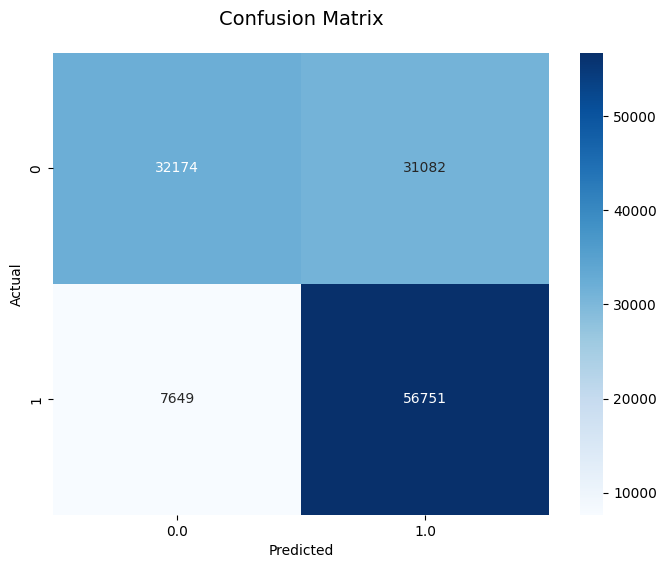

In [16]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

train_accuracy = evaluator.evaluate(train_pred, {evaluator.metricName: "accuracy"})
test_accuracy = evaluator.evaluate(test_pred, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(test_pred, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(test_pred, {evaluator.metricName: "weightedRecall"})
auc = auc_evaluator.evaluate(test_pred)

print("\n\033[1mClassification Metrics:\033[0m")
print(f"{'Training Accuracy:':<25} {train_accuracy:.4f}")
print(f"{'Test Accuracy:':<25} {test_accuracy:.4f}")
print(f"{'Precision:':<25} {precision:.4f}")
print(f"{'Recall:':<25} {recall:.4f}")
print(f"{'AUC-ROC:':<25} {auc:.4f}")

conf_matrix = test_pred.groupBy("label", "prediction").count().collect()

conf_df = spark.createDataFrame(conf_matrix).toPandas()
conf_pivot = conf_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_pivot, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

25/05/31 09:08:33 WARN TaskSetManager: Stage 128 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

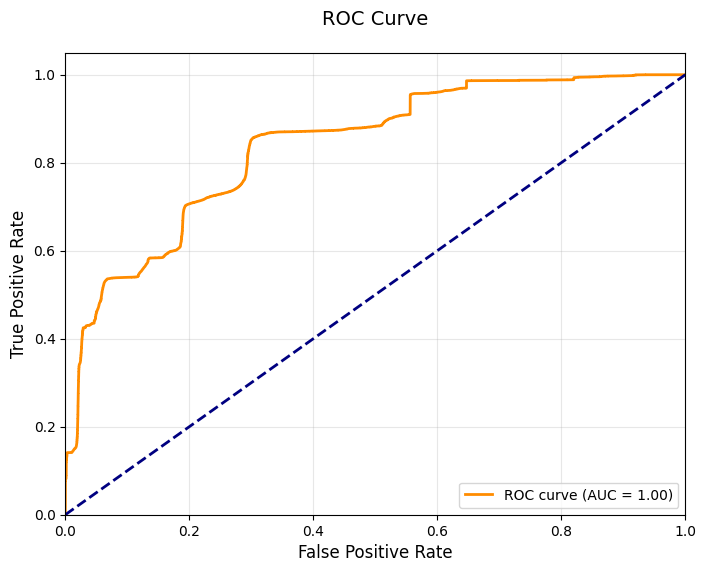

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

test_pd = test_pred.select("label", "probability").toPandas()
test_pd['probability'] = test_pd['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(test_pd['label'], test_pd['probability'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, pad=20)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


In [19]:
num_rows = df_copy.count()
num_cols = len(df_copy.columns)
print(num_rows, num_cols, df_copy.columns)

25/05/31 09:05:13 WARN TaskSetManager: Stage 92 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


638225 15 ['Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'TotLen Fwd Pkts', 'Init Bwd Win Byts', 'Bwd Pkt Len Std', 'Flow Duration', 'Fwd IAT Mean', 'Flow IAT Min', 'Bwd IAT Tot', 'SYN Flag Cnt', 'RST Flag Cnt', 'Flow Pkts/s', 'Flow Byts/s', 'Label']


25/05/31 09:09:07 WARN TaskSetManager: Stage 129 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

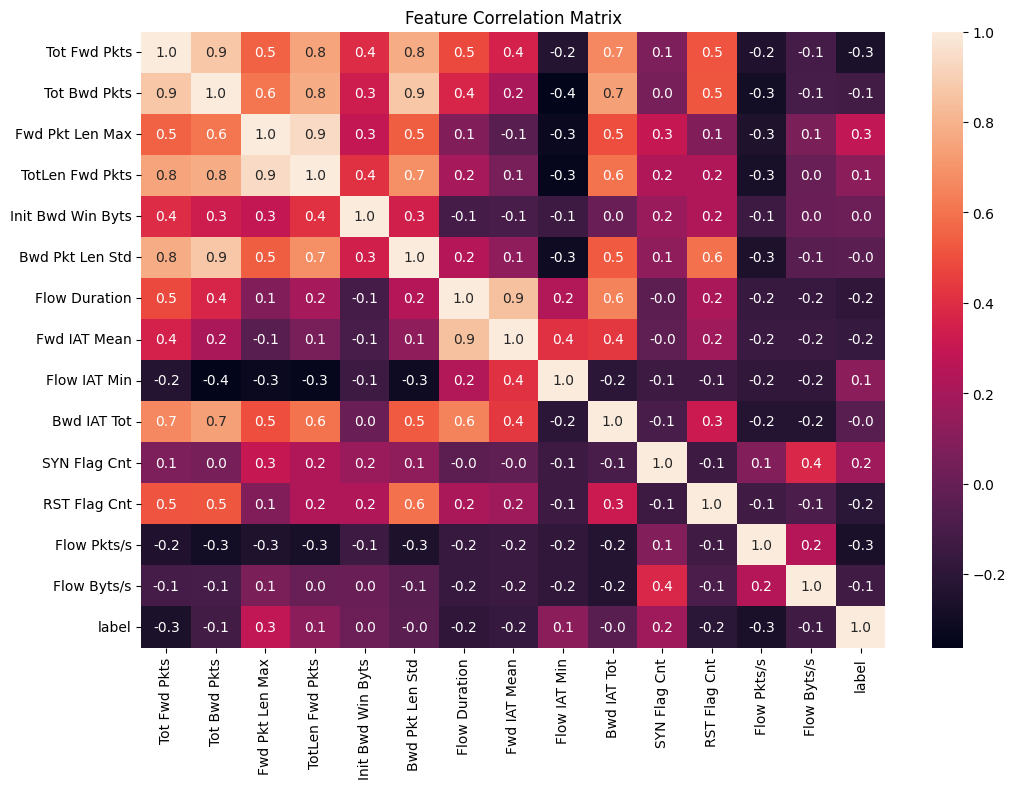

25/05/31 09:09:09 WARN TaskSetManager: Stage 130 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Top correlations with label:
label                1.000000
Fwd Pkt Len Max      0.286342
SYN Flag Cnt         0.173974
Flow IAT Min         0.114826
TotLen Fwd Pkts      0.111721
Init Bwd Win Byts    0.012178
Bwd Pkt Len Std     -0.040009
Bwd IAT Tot         -0.047314
Tot Bwd Pkts        -0.117693
Flow Byts/s         -0.130812
Name: label, dtype: float64


25/05/31 09:09:10 WARN TaskSetManager: Stage 131 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:11 WARN TaskSetManager: Stage 134 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:11 WARN TaskSetManager: Stage 135 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:11 WARN TaskSetManager: Stage 136 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:12 WARN TaskSetManager: Stage 138 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:14 WARN TaskSetManager: Stage 140 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:15 WARN TaskSetManager: Stage 142 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.98     63352
        DDoS       0.98      0.99      0.98     64507

    accuracy                           0.98    127859
   macro avg       0.98      0.98      0.98    127859
weighted avg       0.98      0.98      0.98    127859



25/05/31 09:09:24 WARN TaskSetManager: Stage 162 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

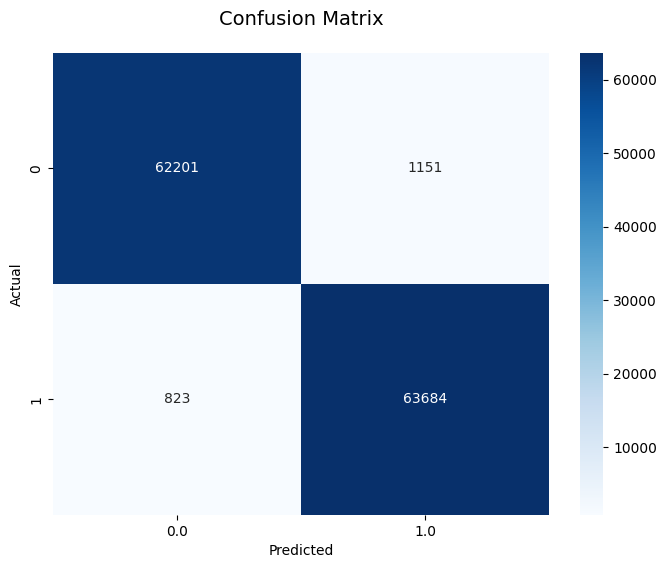

25/05/31 09:09:26 WARN TaskSetManager: Stage 166 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

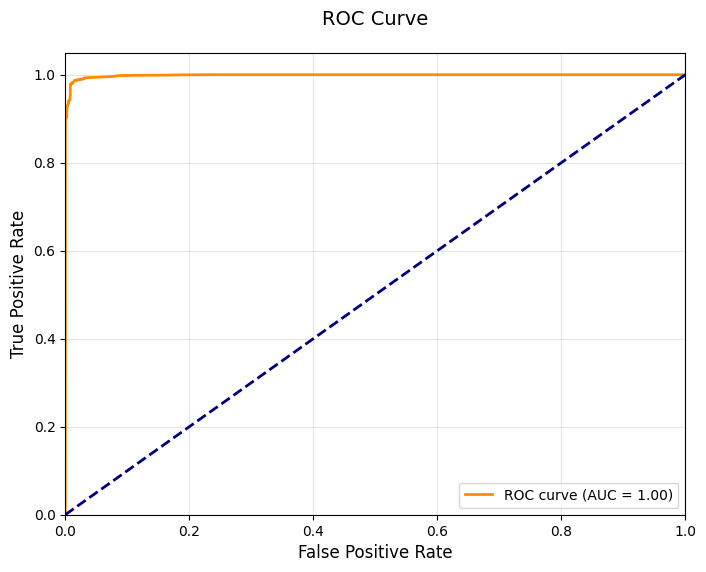

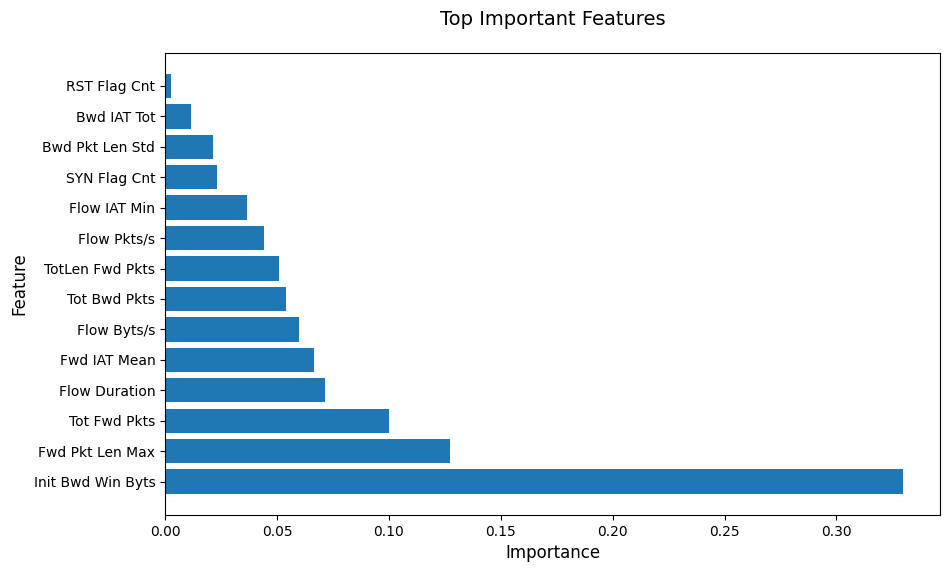

25/05/31 09:09:28 WARN TaskSetManager: Stage 167 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:30 WARN TaskSetManager: Stage 168 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:30 WARN TaskSetManager: Stage 171 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:30 WARN TaskSetManager: Stage 172 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:31 WARN TaskSetManager: Stage 173 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:31 WARN TaskSetManager: Stage 175 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:33 WARN TaskSetManager: Stage 177 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


Best model AUC: 0.9998


In [25]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df_forest = df_copy.alias("df")
label_mapping = {'Benign': 0, 'ddos': 1}
df_forest = df_forest.withColumn('label', F.when(F.col('Label') == 'Benign', 0).otherwise(1))
# df_forest = df_forest.drop('Label')

corr_matrix = df_forest.toPandas().corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
plt.title('Feature Correlation Matrix')
plt.show()

label_correlations = df_forest.toPandas().corr()['label'].sort_values(ascending=False)
print("Top correlations with label:")
print(label_correlations.head(10))

feature_cols = [col for col in df_forest.columns if col != 'label']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_assembled = assembler.transform(df_forest)

train, test = df_assembled.randomSplit([0.8, 0.2], seed=44)

rf = RandomForestClassifier(
    labelCol='label',
    featuresCol='features',
    numTrees=50,
    maxDepth=5,
    minInstancesPerNode=2,
    featureSubsetStrategy='sqrt',
    impurity='gini',
    seed=33,
    subsamplingRate=1.0
)

rf_model = rf.fit(train)

predictions = rf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)

auc_evaluator = BinaryClassificationEvaluator(
    labelCol='label',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

accuracy = evaluator.evaluate(predictions)
auc = auc_evaluator.evaluate(predictions)

pred_pd = predictions.select('label', 'prediction').toPandas()
print("\nClassification Report:")
print(classification_report(pred_pd['label'], pred_pd['prediction'], target_names=['Benign', 'DDoS']))

conf_matrix = predictions.groupBy('label', 'prediction').count().collect()
conf_df = spark.createDataFrame(conf_matrix).toPandas()
conf_pivot = conf_df.pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

pred_pd = predictions.select('label', 'probability').toPandas()
pred_pd['probability'] = pred_pd['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(pred_pd['label'], pred_pd['probability'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, pad=20)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

feature_importance = rf_model.featureImportances.toArray()
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], 
        importance_df['Importance'][:20])
plt.title('Top Important Features', fontsize=14, pad=20)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])
             .addGrid(rf.maxDepth, [5, 10])
             .addGrid(rf.minInstancesPerNode, [2, 5])
             .build())

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol='label'),
    numFolds=3,
    seed=42
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

best_predictions = best_model.transform(test)
best_auc = BinaryClassificationEvaluator(labelCol='label').evaluate(best_predictions)
print(f"\nBest model AUC: {best_auc:.4f}")

25/05/31 09:09:07 WARN TaskSetManager: Stage 129 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

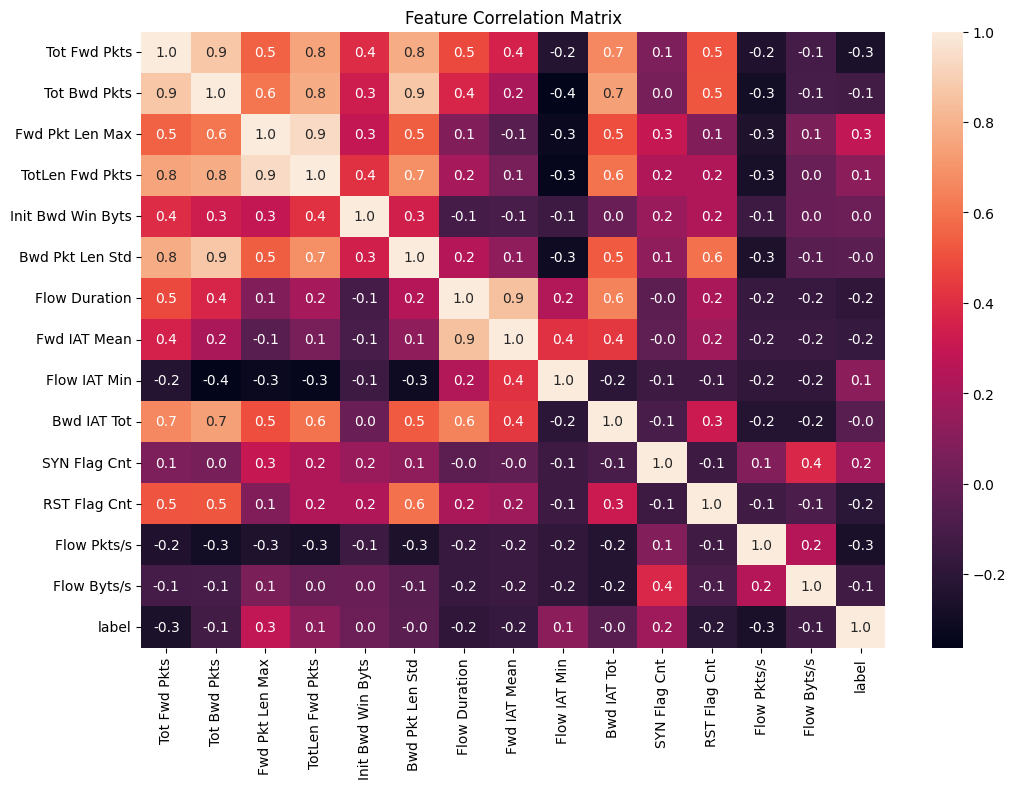

25/05/31 09:09:09 WARN TaskSetManager: Stage 130 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Top correlations with label:
label                1.000000
Fwd Pkt Len Max      0.286342
SYN Flag Cnt         0.173974
Flow IAT Min         0.114826
TotLen Fwd Pkts      0.111721
Init Bwd Win Byts    0.012178
Bwd Pkt Len Std     -0.040009
Bwd IAT Tot         -0.047314
Tot Bwd Pkts        -0.117693
Flow Byts/s         -0.130812
Name: label, dtype: float64


25/05/31 09:09:10 WARN TaskSetManager: Stage 131 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:11 WARN TaskSetManager: Stage 134 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:11 WARN TaskSetManager: Stage 135 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:11 WARN TaskSetManager: Stage 136 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:12 WARN TaskSetManager: Stage 138 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:14 WARN TaskSetManager: Stage 140 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:15 WARN TaskSetManager: Stage 142 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.


Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.98     63352
        DDoS       0.98      0.99      0.98     64507

    accuracy                           0.98    127859
   macro avg       0.98      0.98      0.98    127859
weighted avg       0.98      0.98      0.98    127859



25/05/31 09:09:24 WARN TaskSetManager: Stage 162 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

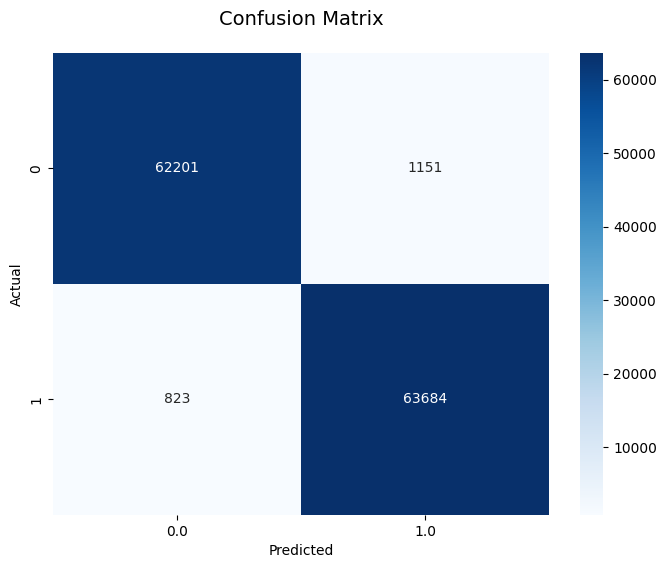

25/05/31 09:09:26 WARN TaskSetManager: Stage 166 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

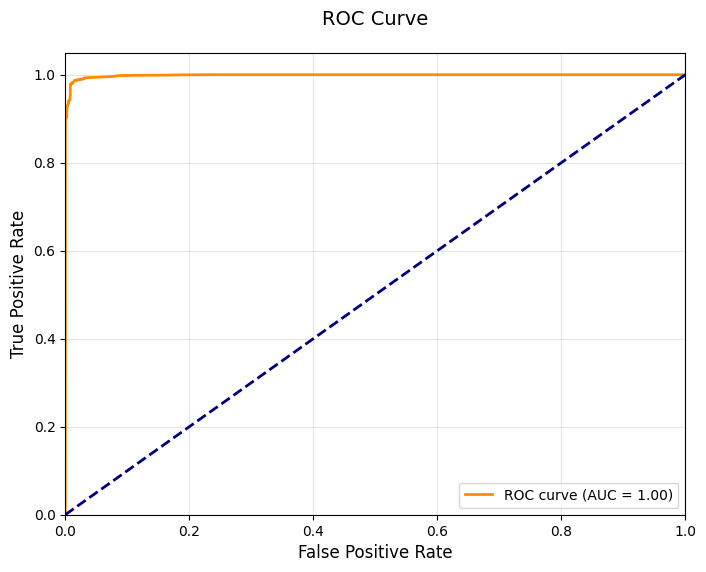

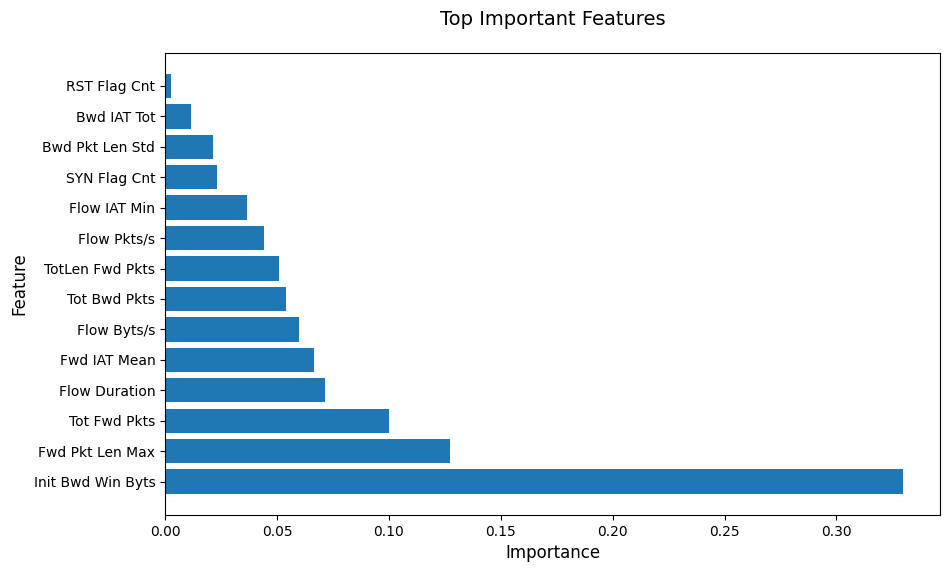

25/05/31 09:09:28 WARN TaskSetManager: Stage 167 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:30 WARN TaskSetManager: Stage 168 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:30 WARN TaskSetManager: Stage 171 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:30 WARN TaskSetManager: Stage 172 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:31 WARN TaskSetManager: Stage 173 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:31 WARN TaskSetManager: Stage 175 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.
25/05/31 09:09:33 WARN TaskSetManager: Stage 177 contains a task of very large size (7343 KiB). The maximum recommended task size is 1000 KiB.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df_forest = df_copy.alias("df")
label_mapping = {'Benign': 0, 'ddos': 1}
df_forest = df_forest.withColumn('label', F.when(F.col('Label') == 'Benign', 0).otherwise(1))
# df_forest = df_forest.drop('Label')

corr_matrix = df_forest.toPandas().corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
plt.title('Feature Correlation Matrix')
plt.show()

label_correlations = df_forest.toPandas().corr()['label'].sort_values(ascending=False)
print("Top correlations with label:")
print(label_correlations.head(10))

feature_cols = [col for col in df_forest.columns if col != 'label']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_assembled = assembler.transform(df_forest)

train, test = df_assembled.randomSplit([0.8, 0.2], seed=44)

rf = RandomForestClassifier(
    labelCol='label',
    featuresCol='features',
    numTrees=50,
    maxDepth=5,
    minInstancesPerNode=2,
    featureSubsetStrategy='sqrt',
    impurity='gini',
    seed=33,
    subsamplingRate=1.0
)

rf_model = rf.fit(train)

predictions = rf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)

auc_evaluator = BinaryClassificationEvaluator(
    labelCol='label',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

accuracy = evaluator.evaluate(predictions)
auc = auc_evaluator.evaluate(predictions)

pred_pd = predictions.select('label', 'prediction').toPandas()
print("\nClassification Report:")
print(classification_report(pred_pd['label'], pred_pd['prediction'], target_names=['Benign', 'DDoS']))

conf_matrix = predictions.groupBy('label', 'prediction').count().collect()
conf_df = spark.createDataFrame(conf_matrix).toPandas()
conf_pivot = conf_df.pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

pred_pd = predictions.select('label', 'probability').toPandas()
pred_pd['probability'] = pred_pd['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(pred_pd['label'], pred_pd['probability'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, pad=20)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

feature_importance = rf_model.featureImportances.toArray()
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], 
        importance_df['Importance'][:20])
plt.title('Top Important Features', fontsize=14, pad=20)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])
             .addGrid(rf.maxDepth, [5, 10])
             .addGrid(rf.minInstancesPerNode, [2, 5])
             .build())

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol='label'),
    numFolds=3,
    seed=42
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

best_predictions = best_model.transform(test)
best_auc = BinaryClassificationEvaluator(labelCol='label').evaluate(best_predictions)
print(f"\nBest model AUC: {best_auc:.4f}")

In [1]:
spark.stop()

NameError: name 'spark' is not defined